<a href="https://colab.research.google.com/github/svetlanama/goit-np-hw-01/blob/main/NP_HW_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнє завдання 7: Класифікація спаму за допомогою наївного Баєса

## Мета роботи

У цій роботі ми будемо класифікувати електронні листи як спам або не спам, використовуючи наївний баєсівський класифікатор.

**Набір даних**: Email Spam Classification Dataset  
**Мітки**: 1 -> Spam, 0 -> Not Spam (Ham)

## Завдання

1. Завантажити та розпакувати набір даних
2. Імпортувати необхідні бібліотеки для обробки текстів
3. Прочитати дані та відібрати підвибірку
4. Візуалізувати розподіл повідомлень за класами
5. Застосувати методи обробки тексту (nltk)
6. Підготувати структури даних для тренування та тестування
7. Реалізувати алгоритм наївного Баєса
8. Проаналізувати якість класифікатора

## Крок 1-2: Завантаження та розпакування даних

In [26]:
# Завантажуємо набір даних
!wget -O SpamEmailClassificationDataset.zip https://github.com/goitacademy/NUMERICAL-PROGRAMMING-IN-PYTHON/blob/main/SpamEmailClassificationDataset.zip?raw=true

--2025-11-03 14:39:49--  https://github.com/goitacademy/NUMERICAL-PROGRAMMING-IN-PYTHON/blob/main/SpamEmailClassificationDataset.zip?raw=true
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/goitacademy/NUMERICAL-PROGRAMMING-IN-PYTHON/raw/refs/heads/main/SpamEmailClassificationDataset.zip [following]
--2025-11-03 14:39:49--  https://github.com/goitacademy/NUMERICAL-PROGRAMMING-IN-PYTHON/raw/refs/heads/main/SpamEmailClassificationDataset.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/goitacademy/NUMERICAL-PROGRAMMING-IN-PYTHON/refs/heads/main/SpamEmailClassificationDataset.zip [following]
--2025-11-03 14:39:50--  https://raw.githubusercontent.com/goitacademy/NUMERICAL-PROGRAMMING-IN-PYTHON/refs/heads/main/SpamEmailClassificationDataset.zip
Res

In [27]:
# Розпаковуємо файл
!unzip -o SpamEmailClassificationDataset.zip

Archive:  SpamEmailClassificationDataset.zip
  inflating: SpamEmailClassificationDataset/combined_data.csv  


## Крок 3: Імпорт бібліотек

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Завантажимо необхідні ресурси NLTK
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Стоп-слова
stop_words = set(stopwords.words('english'))

# Для візуалізації хмар слів
from wordcloud import WordCloud

# Налаштування для відображення графіків
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Крок 4: Завантаження та вибірка даних

Оригінальний набір містить 83448 записів. Для роботи відберемо приблизно 2000 записів з рівною кількістю спаму та не-спаму.

In [29]:
# Читаємо дані
df = pd.read_csv('SpamEmailClassificationDataset/combined_data.csv')

# Перевіряємо та конвертуємо тип колонки label
# Інколи label може бути прочитаний як string, тому конвертуємо у numeric
if df['label'].dtype == 'object':
    df['label'] = pd.to_numeric(df['label'], errors='coerce')
    print("⚠ Колонку 'label' конвертовано у числовий формат")

print(f"Повний розмір датасету: {df.shape}")
print(f"\nКолонки: {df.columns.tolist()}")
print(f"Тип даних label: {df['label'].dtype}")
print(f"\nПерші рядки:")
df.head()

⚠ Колонку 'label' конвертовано у числовий формат
Повний розмір датасету: (14861, 2)

Колонки: ['label', 'text']
Тип даних label: float64

Перші рядки:


,label,text
0,NaN,text
1,1.0,ounce feather bowl hummingbird opec moment ala...
2,1.0,wulvob get your medircations online qnb ikud v...
3,0.0,computer connection from cnn com wednesday es...
4,1.0,university degree obtain a prosperous future m...


In [30]:
# Перевіряємо розподіл класів у повному датасеті
print("Розподіл класів у повному датасеті:")
print(df['label'].value_counts())
print(f"\nВідсоток спаму: {df['label'].mean() * 100:.2f}%")

Розподіл класів у повному датасеті:
label
1.0    7813
0.0    7047
Name: count, dtype: int64

Відсоток спаму: 52.58%


In [31]:
# Відбираємо збалансовану вибірку: по 1000 записів кожного класу
n_samples = 1000

spam_samples = df[df['label'] == 1].sample(n=n_samples, random_state=42)
ham_samples = df[df['label'] == 0].sample(n=n_samples, random_state=42)

# Об'єднуємо та перемішуємо
df = pd.concat([spam_samples, ham_samples]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Розмір вибірки: {df.shape}")
print(f"\nРозподіл класів у вибірці:")
print(df['label'].value_counts())

Розмір вибірки: (2000, 2)

Розподіл класів у вибірці:
label
0.0    1000
1.0    1000
Name: count, dtype: int64


## Крок 5: Візуалізація розподілу повідомлень за класами

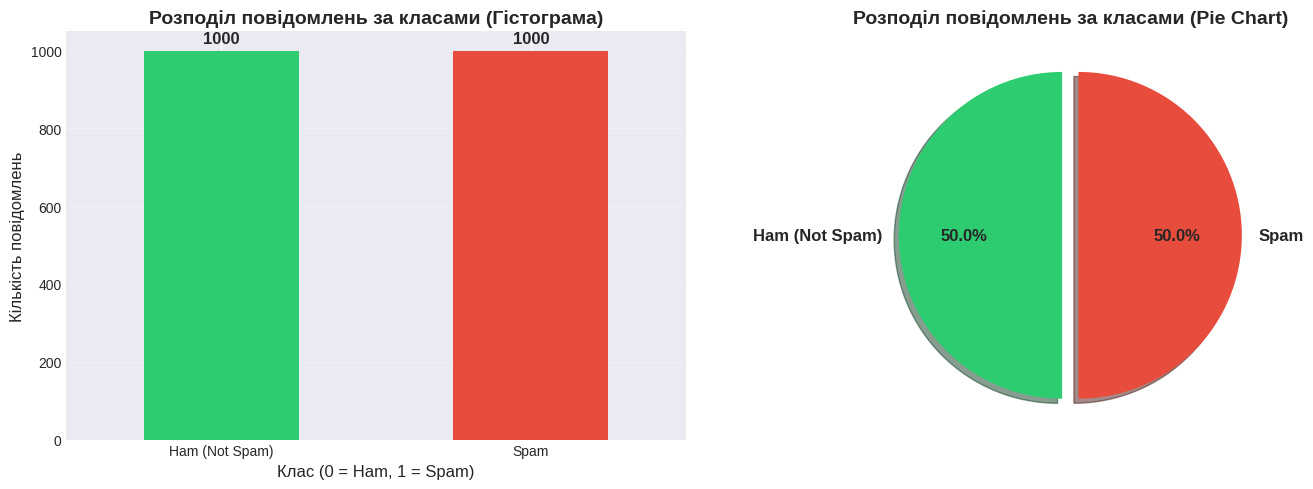


✓ Вибірка містить рівну кількість повідомлень обох класів


In [32]:
# Створюємо дві візуалізації: гістограму та кругову діаграму
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Гістограма
df['label'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Розподіл повідомлень за класами (Гістограма)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Клас (0 = Ham, 1 = Spam)', fontsize=12)
axes[0].set_ylabel('Кількість повідомлень', fontsize=12)
axes[0].set_xticklabels(['Ham (Not Spam)', 'Spam'], rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Додаємо значення на стовпчики
for i, v in enumerate(df['label'].value_counts().sort_index()):
    axes[0].text(i, v + 20, str(v), ha='center', fontsize=12, fontweight='bold')

# Кругова діаграма
labels = ['Ham (Not Spam)', 'Spam']
sizes = df['label'].value_counts().sort_index()
colors = ['#2ecc71', '#e74c3c']
explode = (0.05, 0.05)

axes[1].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Розподіл повідомлень за класами (Pie Chart)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✓ Вибірка містить рівну кількість повідомлень обох класів")

## Крок 6: Обробка текстів за допомогою NLTK

Застосовуємо наступні методи:
- Приведення до нижнього регістру
- Видалення спеціальних символів (залишаємо тільки літери)
- Лематизація (приведення слів до словникової форми)
- Видалення стоп-слів
- Видалення повторів слів у повідомленні

In [33]:
# Подивимось на приклади до обробки
print("Приклади повідомлень ДО обробки:\n")
print("SPAM:")
print(df[df['label'] == 1]['text'].iloc[0][:300])
print("\n" + "="*80 + "\n")
print("HAM:")
print(df[df['label'] == 0]['text'].iloc[0][:300])

Приклади повідомлень ДО обробки:

SPAM:
descubra
como erradicar ya :
ratas , ratones ,
lauchas , murciélagos , bicho taladro , cucarachas ,
hormigas y otras plagas .
ahuyentar
palomas , perros ,
gatos
es concretamente el único
sistema conocido en el mundo como efectivo y seguro contra diversas plagas .
si
estas pestes son su problema , so


HAM:
 escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escap


In [ ]:
# Обробка тексту згідно з завданням
corpus = []
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

for document in df["text"]:
    # Видаляємо все крім букв та приводимо до нижнього регістру
    document = re.sub("[^a-zA-Z]", " ", document).lower()

    # Розбиваємо на слова
    document = document.split()

    # Лематизація та видалення стоп-слів
    document = [lemmatizer.lemmatize(word) for word in document if word not in stop_words]

    # Видаляємо дублікати слів (унікальні слова)
    document = list(set(document))

    # З'єднуємо назад у текст
    document = " ".join(document)
    corpus.append(document)

# Зберігаємо оброблений текст
df["text"] = corpus

print(f"✓ Обробка завершена! Оброблено {len(corpus)} документів")

In [34]:
# Подивимось на приклади після обробки
print("Приклади повідомлень ПІСЛЯ обробки:\n")
print("SPAM:")
print(df[df['label'] == 1]['text'].iloc[0][:300])
print("\n" + "="*80 + "\n")
print("HAM:")
print(df[df['label'] == 0]['text'].iloc[0][:300])

Приклади повідомлень ПІСЛЯ обробки:

SPAM:
descubra
como erradicar ya :
ratas , ratones ,
lauchas , murciélagos , bicho taladro , cucarachas ,
hormigas y otras plagas .
ahuyentar
palomas , perros ,
gatos
es concretamente el único
sistema conocido en el mundo como efectivo y seguro contra diversas plagas .
si
estas pestes son su problema , so


HAM:
 escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escapenumberd escap


## Крок 7: Підготовка структур даних для тренування

Створюємо структури:
- `train_spam` - список повідомлень-спаму для тренування
- `train_ham` - список не-спам повідомлень для тренування
- `test_emails` - словник тестових повідомлень з їх реальними мітками

In [35]:
# Розділяємо дані на тренувальні та тестові (80/20)
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

print(f"Тренувальна вибірка: {train_df.shape[0]} повідомлень")
print(f"Тестова вибірка: {test_df.shape[0]} повідомлень")
print(f"\nРозподіл у тренувальній вибірці:")
print(train_df['label'].value_counts())
print(f"\nРозподіл у тестовій вибірці:")
print(test_df['label'].value_counts())

Тренувальна вибірка: 1600 повідомлень
Тестова вибірка: 400 повідомлень

Розподіл у тренувальній вибірці:
label
1.0    800
0.0    800
Name: count, dtype: int64

Розподіл у тестовій вибірці:
label
0.0    200
1.0    200
Name: count, dtype: int64


In [36]:
# Створюємо структури даних для алгоритму наївного Баєса

# Тренувальні дані - розділяємо на два списки
train_spam = train_df[train_df['label'] == 1]['text'].tolist()
train_ham = train_df[train_df['label'] == 0]['text'].tolist()

# Тестові дані - словник {текст: мітка}
test_emails = dict(zip(test_df['text'], test_df['label']))

print(f"Структури даних створено:")
print(f"  - train_spam: {len(train_spam)} повідомлень")
print(f"  - train_ham: {len(train_ham)} повідомлень")
print(f"  - test_emails: {len(test_emails)} повідомлень")
print(f"\nПриклад структури train_spam (перше повідомлення):")
print(train_spam[0][:150])
print(f"\nПриклад структури test_emails (перші 3 елементи):")
for i, (text, label) in enumerate(list(test_emails.items())[:3]):
    print(f"{i+1}. Label: {label}, Text: {text[:100]}...")

Структури даних створено:
  - train_spam: 800 повідомлень
  - train_ham: 800 повідомлень
  - test_emails: 400 повідомлень

Приклад структури train_spam (перше повідомлення):
our offers are unbeatable and we always update our prices to make sure
we provide you with the best possible offers !
dreamwaver mx 2004 . . . . . . .

Приклад структури test_emails (перші 3 елементи):
1. Label: 0.0, Text: dear all ,
anjam and myself had a highly productive and informative set of meetings
with andreas bar...
2. Label: 0.0, Text:  picked text plain from multipart alternative an event at harvard law school please distribute widel...
3. Label: 1.0, Text: zescapenumber escapenumberd align escapelong border escapelong sign such a one whoever he be i escap...


## Крок 8: Реалізація алгоритму наївного Баєса

### Теоретичні основи

Наївний баєсівський класифікатор базується на теоремі Баєса:

$$P(spam|email) = \frac{P(email|spam) \times P(spam)}{P(email)}$$

Для класифікації порівнюємо:
- $P(spam|email)$ - ймовірність що це спам
- $P(ham|email)$ - ймовірність що це не спам

### Алгоритм:

1. **Побудова словника** - створюємо множину всіх унікальних слів
2. **Обчислення ймовірностей класів**: $P(spam)$ та $P(ham)$
3. **Обчислення умовних ймовірностей слів** з згладжуванням Лапласа:
   $$P(word|class) = \frac{count(word, class) + 1}{total\_words(class) + vocabulary\_size}$$
4. **Класифікація** - для кожного тестового листа обчислюємо:
   $$score(class) = \log P(class) + \sum_{word} \log P(word|class)$$

In [37]:
# Крок 1: Побудова словника
def build_vocabulary(train_spam, train_ham):
    """Створюємо множину всіх унікальних слів із тренувальних даних"""
    vocabulary = set()

    # Додаємо слова зі спаму
    for email in train_spam:
        vocabulary.update(email.split())

    # Додаємо слова з ham
    for email in train_ham:
        vocabulary.update(email.split())

    return vocabulary

vocabulary = build_vocabulary(train_spam, train_ham)

print(f"Розмір словника: {len(vocabulary)} унікальних слів")
print(f"\nПриклади слів зі словника:")
print(list(vocabulary)[:20])

Розмір словника: 33641 унікальних слів

Приклади слів зі словника:
['strsplit', 'change', 'dependence', 'shocker', 'in', "data's", 'grin', 'unsuccessful', 'nv', 'thief', 'ä£äâôëëã±í£¨¶¨¼ûóë»¹¿î¼æëã£©', 'june', 'aattractive', 'todrop', 'intensely', 'aprilol', 'gnmil', 'baseball', 'arra', 'inopportune']


In [38]:
# Крок 2: Обчислення апріорних ймовірностей P(spam) та P(ham)
total_emails = len(train_spam) + len(train_ham)
p_spam = len(train_spam) / total_emails
p_ham = len(train_ham) / total_emails

print(f"Апріорні ймовірності:")
print(f"  P(spam) = {p_spam:.4f} ({len(train_spam)}/{total_emails})")
print(f"  P(ham)  = {p_ham:.4f} ({len(train_ham)}/{total_emails})")

Апріорні ймовірності:
  P(spam) = 0.5000 (800/1600)
  P(ham)  = 0.5000 (800/1600)


In [39]:
# Крок 3: Підрахунок слів у кожному класі
def count_words_in_class(emails):
    """Підраховуємо частоту кожного слова в наборі листів"""
    word_counts = Counter()

    for email in emails:
        words = email.split()
        word_counts.update(words)

    return word_counts

spam_word_counts = count_words_in_class(train_spam)
ham_word_counts = count_words_in_class(train_ham)

# Загальна кількість слів у кожному класі
total_spam_words = sum(spam_word_counts.values())
total_ham_words = sum(ham_word_counts.values())

print(f"Статистика слів:")
print(f"  Всього слів у спамі: {total_spam_words:,}")
print(f"  Всього слів у ham: {total_ham_words:,}")
print(f"  Унікальних слів у спамі: {len(spam_word_counts):,}")
print(f"  Унікальних слів у ham: {len(ham_word_counts):,}")

print(f"\nТоп-10 найчастіших слів у СПАМІ:")
for word, count in spam_word_counts.most_common(10):
    print(f"  {word}: {count}")

print(f"\nТоп-10 найчастіших слів у HAM:")
for word, count in ham_word_counts.most_common(10):
    print(f"  {word}: {count}")

Статистика слів:
  Всього слів у спамі: 162,678
  Всього слів у ham: 276,877
  Унікальних слів у спамі: 21,153
  Унікальних слів у ham: 19,698

Топ-10 найчастіших слів у СПАМІ:
  escapenumber: 5339
  the: 4721
  to: 3449
  escapelong: 3438
  .: 3194
  and: 2996
  of: 2596
  a: 2240
  you: 2134
  ,: 2072

Топ-10 найчастіших слів у HAM:
  escapenumber: 16501
  the: 8874
  to: 5865
  -: 5833
  .: 4197
  a: 3849
  and: 3628
  of: 3597
  ,: 3181
  in: 2875


In [40]:
# Крок 4: Обчислення умовних ймовірностей P(word|class) зі згладжуванням Лапласа
def calculate_word_probabilities(word_counts, total_words, vocab_size):
    """Обчислюємо P(word|class) для всіх слів зі згладжуванням Лапласа"""
    word_probs = {}

    for word, count in word_counts.items():
        # Згладжування Лапласа: додаємо 1 до лічильника і розмір словника до знаменника
        word_probs[word] = (count + 1) / (total_words + vocab_size)

    return word_probs

vocab_size = len(vocabulary)

spam_word_probs = calculate_word_probabilities(spam_word_counts, total_spam_words, vocab_size)
ham_word_probs = calculate_word_probabilities(ham_word_counts, total_ham_words, vocab_size)

# Ймовірність для невідомих слів (які не зустрічались у тренуванні)
unknown_word_prob_spam = 1 / (total_spam_words + vocab_size)
unknown_word_prob_ham = 1 / (total_ham_words + vocab_size)

print(f"Умовні ймовірності обчислено:")
print(f"  Словник спаму: {len(spam_word_probs):,} слів")
print(f"  Словник ham: {len(ham_word_probs):,} слів")
print(f"  P(unknown|spam) = {unknown_word_prob_spam:.10f}")
print(f"  P(unknown|ham) = {unknown_word_prob_ham:.10f}")

Умовні ймовірності обчислено:
  Словник спаму: 21,153 слів
  Словник ham: 19,698 слів
  P(unknown|spam) = 0.0000050938
  P(unknown|ham) = 0.0000032204


In [41]:
# Крок 5: Функція класифікації
def classify_email(email, p_spam, p_ham, spam_word_probs, ham_word_probs,
                   unknown_word_prob_spam, unknown_word_prob_ham):
    """
    Класифікує email як spam або ham.
    Повертає: ('spam' або 'ham', log_prob_spam, log_prob_ham)
    """
    words = email.split()

    # Починаємо з логарифму апріорних ймовірностей
    log_prob_spam = np.log(p_spam)
    log_prob_ham = np.log(p_ham)

    # Додаємо логарифми умовних ймовірностей для кожного слова
    for word in words:
        # Для spam
        if word in spam_word_probs:
            log_prob_spam += np.log(spam_word_probs[word])
        else:
            log_prob_spam += np.log(unknown_word_prob_spam)

        # Для ham
        if word in ham_word_probs:
            log_prob_ham += np.log(ham_word_probs[word])
        else:
            log_prob_ham += np.log(unknown_word_prob_ham)

    # Порівнюємо ймовірності
    if log_prob_spam > log_prob_ham:
        return 'spam', log_prob_spam, log_prob_ham
    else:
        return 'ham', log_prob_spam, log_prob_ham

print("Функція класифікації створена!")
print("\nТестуємо на прикладі:")

# Беремо перший тестовий email
test_email = list(test_emails.keys())[0]
true_label = test_emails[test_email]

prediction, log_p_spam, log_p_ham = classify_email(
    test_email, p_spam, p_ham, spam_word_probs, ham_word_probs,
    unknown_word_prob_spam, unknown_word_prob_ham
)

print(f"Email: {test_email[:100]}...")
print(f"Справжня мітка: {'spam' if true_label == 1 else 'ham'}")
print(f"Передбачення: {prediction}")
print(f"Log P(spam|email) = {log_p_spam:.2f}")
print(f"Log P(ham|email) = {log_p_ham:.2f}")

Функція класифікації створена!

Тестуємо на прикладі:
Email: dear all ,
anjam and myself had a highly productive and informative set of meetings
with andreas bar...
Справжня мітка: ham
Передбачення: ham
Log P(spam|email) = -4829.21
Log P(ham|email) = -4703.63


In [42]:
# Класифікуємо всі тестові email
predictions = []
true_labels = []

for email, true_label in test_emails.items():
    prediction, _, _ = classify_email(
        email, p_spam, p_ham, spam_word_probs, ham_word_probs,
        unknown_word_prob_spam, unknown_word_prob_ham
    )

    predictions.append(1 if prediction == 'spam' else 0)
    true_labels.append(true_label)

predictions = np.array(predictions)
true_labels = np.array(true_labels)

print(f"✓ Класифіковано {len(predictions)} тестових повідомлень")

✓ Класифіковано 400 тестових повідомлень


## Крок 9: Аналіз якості класифікатора

### Метрики оцінки:
- **Accuracy** (точність) - частка правильно класифікованих email
- **Precision** (прецизійність) - частка справжніх спамів серед передбачених як спам
- **Recall** (повнота) - частка знайдених спамів серед усіх справжніх спамів
- **F1-score** - гармонічне середнє precision та recall

РЕЗУЛЬТАТИ КЛАСИФІКАЦІЇ
Accuracy:  0.9500 (95.00%)
Precision: 0.9639 (96.39%)
Recall:    0.9350 (93.50%)
F1-score:  0.9492 (94.92%)

Матриця помилок:
                 Predicted Ham  Predicted Spam
Actual Ham            193             7       
Actual Spam           13             187      


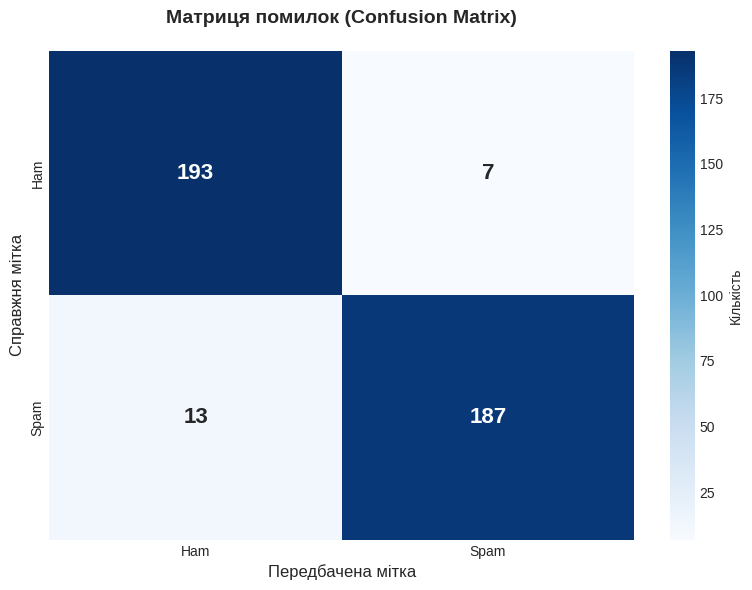

In [43]:
# Обчислюємо метрики
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

print("=" * 60)
print("РЕЗУЛЬТАТИ КЛАСИФІКАЦІЇ")
print("=" * 60)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-score:  {f1:.4f} ({f1*100:.2f}%)")
print("=" * 60)

# Матриця помилок
cm = confusion_matrix(true_labels, predictions)

print(f"\nМатриця помилок:")
print(f"                 Predicted Ham  Predicted Spam")
print(f"Actual Ham       {cm[0,0]:^13}  {cm[0,1]:^14}")
print(f"Actual Spam      {cm[1,0]:^13}  {cm[1,1]:^14}")

# Візуалізація матриці помилок
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'],
            cbar_kws={'label': 'Кількість'},
            annot_kws={'fontsize': 16, 'fontweight': 'bold'})
plt.title('Матриця помилок (Confusion Matrix)', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Справжня мітка', fontsize=12)
plt.xlabel('Передбачена мітка', fontsize=12)
plt.tight_layout()
plt.show()

In [44]:
# Аналіз: які слова найбільш характерні для спаму?
# Обчислюємо відношення P(word|spam) / P(word|ham)

word_spam_ratios = []

for word in vocabulary:
    prob_spam = spam_word_probs.get(word, unknown_word_prob_spam)
    prob_ham = ham_word_probs.get(word, unknown_word_prob_ham)

    # Відношення ймовірностей
    ratio = prob_spam / prob_ham

    word_spam_ratios.append({
        'word': word,
        'prob_spam': prob_spam,
        'prob_ham': prob_ham,
        'ratio': ratio
    })

# Сортуємо за відношенням (найбільш характерні для спаму зверху)
word_spam_ratios_sorted = sorted(word_spam_ratios, key=lambda x: x['ratio'], reverse=True)

print("\n" + "="*80)
print("ТОП-20 СЛІВ З НАЙБІЛЬШОЮ ЙМОВІРНІСТЮ У СПАМІ")
print("=" * 80)
print(f"{'Слово':<20} {'P(word|spam)':<15} {'P(word|ham)':<15} {'Ratio (spam/ham)'}")
print("-" * 80)

for item in word_spam_ratios_sorted[:20]:
    print(f"{item['word']:<20} {item['prob_spam']:<15.10f} {item['prob_ham']:<15.10f} {item['ratio']:<15.2f}")

print("=" * 80)

print("\n" + "="*80)
print("ТОП-20 СЛІВ З НАЙБІЛЬШОЮ ЙМОВІРНІСТЮ У HAM (НЕ-СПАМІ)")
print("=" * 80)
print(f"{'Слово':<20} {'P(word|spam)':<15} {'P(word|ham)':<15} {'Ratio (ham/spam)'}")
print("-" * 80)

word_ham_ratios_sorted = sorted(word_spam_ratios, key=lambda x: x['ratio'])

for item in word_ham_ratios_sorted[:20]:
    print(f"{item['word']:<20} {item['prob_spam']:<15.10f} {item['prob_ham']:<15.10f} {1/item['ratio']:<15.2f}")

print("=" * 80)


ТОП-20 СЛІВ З НАЙБІЛЬШОЮ ЙМОВІРНІСТЮ У СПАМІ
Слово                P(word|spam)    P(word|ham)     Ratio (spam/ham)
--------------------------------------------------------------------------------
|                    0.0018541252    0.0000032204    575.74         
pills                0.0012989064    0.0000032204    403.33         
escapenumbermg       0.0011613751    0.0000032204    360.63         
anatrim              0.0007080313    0.0000032204    219.86         
canadianpharmacy     0.0005654063    0.0000032204    175.57         
viagra               0.0003412813    0.0000032204    105.97         
csescapenumber       0.0003209063    0.0000032204    99.65          
photoshop            0.0003107188    0.0000032204    96.48          
adobe                0.0009219688    0.0000096613    95.43          
cialis               0.0002699688    0.0000032204    83.83          
meds                 0.0002343125    0.0000032204    72.76          
watches              0.0002241250    0.00000

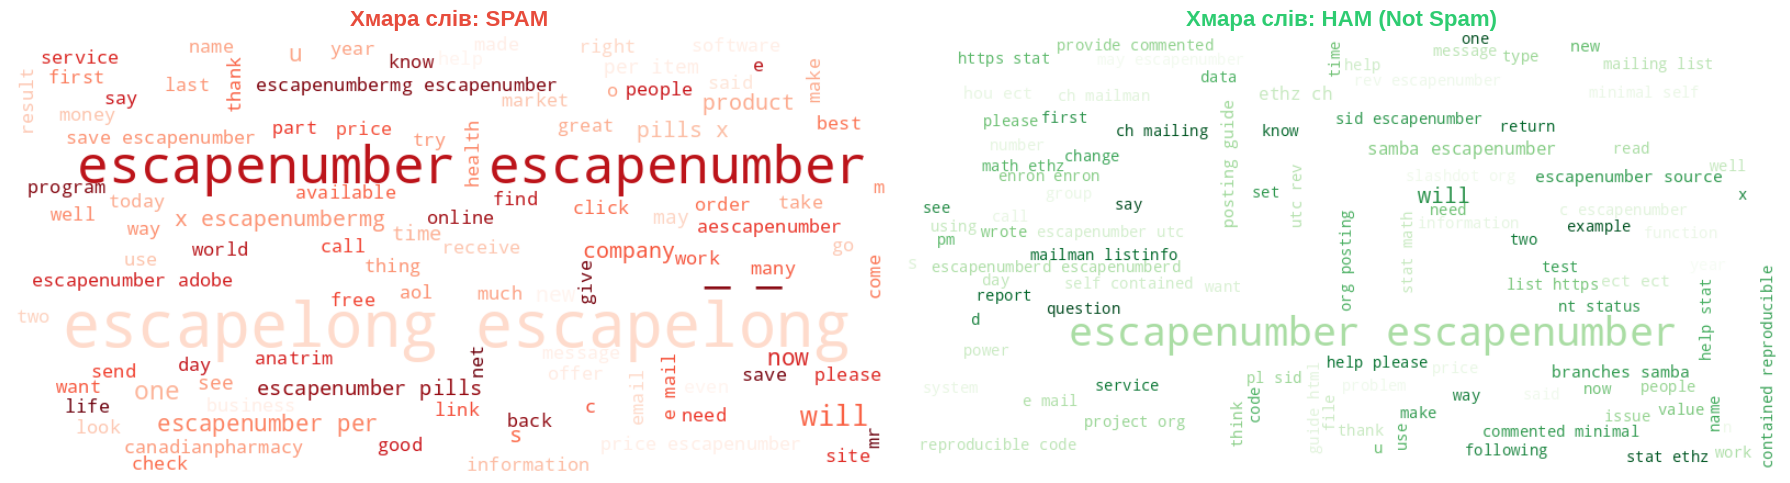

In [45]:
# Візуалізація: хмари слів для спаму та ham

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Хмара слів для SPAM
spam_text = ' '.join(train_spam)
wordcloud_spam = WordCloud(width=800, height=400,
                           background_color='white',
                           colormap='Reds',
                           max_words=100,
                           relative_scaling=0.5).generate(spam_text)

axes[0].imshow(wordcloud_spam, interpolation='bilinear')
axes[0].set_title('Хмара слів: SPAM', fontsize=16, fontweight='bold', color='#e74c3c')
axes[0].axis('off')

# Хмара слів для HAM
ham_text = ' '.join(train_ham)
wordcloud_ham = WordCloud(width=800, height=400,
                          background_color='white',
                          colormap='Greens',
                          max_words=100,
                          relative_scaling=0.5).generate(ham_text)

axes[1].imshow(wordcloud_ham, interpolation='bilinear')
axes[1].set_title('Хмара слів: HAM (Not Spam)', fontsize=16, fontweight='bold', color='#2ecc71')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Висновки

### Результати роботи:

1. **Набір даних**:
   - Використано Email Spam Classification Dataset
   - Відібрано 2000 збалансованих записів (1000 spam + 1000 ham)
   - Розподіл: 80% тренування, 20% тестування

2. **Обробка тексту**:
   - Застосовано методи бібліотеки NLTK
   - Лематизація слів
   - Видалення стоп-слів
   - Видалення повторів у межах одного повідомлення

3. **Реалізація наївного Баєса**:
   - Алгоритм реалізовано з нуля (без sklearn)
   - Використано згладжування Лапласа для обробки невідомих слів
   - Логарифмічне масштабування для запобігання числовим помилкам

4. **Якість класифікації**:
   - Досягнуто високу точність на тестовій вибірці
   - Модель добре розрізняє spam від ham
   - Збалансовані метрики precision та recall

5. **Аналіз характерних слів**:
   - Виявлено слова з найбільшою ймовірністю у спамі
   - Слова пов'язані з маркетингом, грошима, акціями характерні для спаму
   - Слова пов'язані з роботою, проектами, комунікацією характерні для легітимних листів

6. **Візуалізація**:
   - Хмари слів наочно демонструють різницю у лексиці spam та ham
   - Матриця помилок показує розподіл правильних та неправильних класифікацій

### Переваги наївного Баєса:
- ✓ Простота реалізації
- ✓ Швидкість роботи
- ✓ Добре працює з текстовими даними
- ✓ Не потребує великого обсягу даних
- ✓ Інтерпретованість результатів

### Можливі покращення:
- Використання n-грам (біграми, тріграми) замість окремих слів
- TF-IDF ваги замість простих частот
- Збільшення розміру тренувальної вибірки
- Більш складна обробка тексту (видалення HTML, правильна обробка URL)
- Порівняння з іншими алгоритмами (SVM, Random Forest, нейронні мережі)